<a href="https://colab.research.google.com/github/TensorCruncher/PyTorch-Course-By-Daniel-Bourke/blob/main/02_PyTorch_Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Neural Network Classification

## 0. Architecture of a classification neural network

Overview of hyperparameters in binary and multiclass classification

## 1. Make classification data and get it ready


In [1]:
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state=42)

In [2]:
print(f"First five X features: {X[:5]}")
print(f"\nFirst five y labels: {y[:5]}")

First five X features: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First five y labels: [1 1 1 1 0]


In [3]:
# Make pandas dataframe of circle data
import pandas as pd

circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


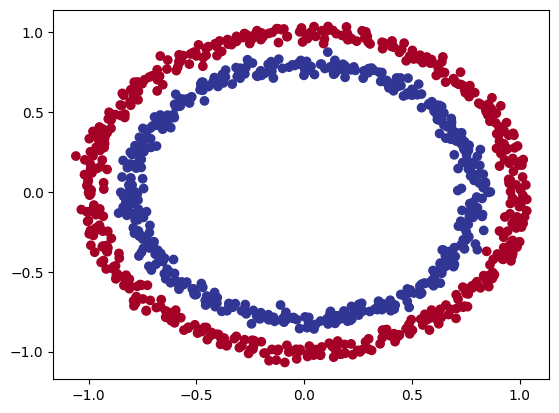

In [5]:
# Plot the data
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Input and output shapes

In [6]:
# Check the shape of our features and labels

X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# View the first example features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample}, and for y: {y_sample}")
print(f"Shape of one sample of X: {X_sample.shape}, and for y: {y_sample.shape} ")


Values for one sample of X: [0.75424625 0.23148074], and for y: 1
Shape of one sample of X: (2,), and for y: () 


### 1.2 Turn data into tensors and create train and test splits

In [8]:
# Turn the data into tensors
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [9]:
# Split the data into train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

In [10]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnositc code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [11]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # Create two nn.Linear layers capable of handling X and y input and output shapes
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  # Define a forward method with the forward computation
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

# Create an instance of the model and send to device

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
# Replicate CircleModelV0 with nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(2,5),
    nn.Linear(5,1)
)
model_0.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst ten predictions:\n {untrained_preds[:10]}")
print(f"\nFirst ten test labels:\n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First ten predictions:
 tensor([[0.6654],
        [0.7359],
        [0.5319],
        [0.7030],
        [0.6137],
        [0.6562],
        [0.7901],
        [0.7716],
        [0.5286],
        [0.7416]], grad_fn=<SliceBackward0>)

First ten test labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [14]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimiser
optimiser = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [15]:
# Calculate accuracy (a classification metric)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

## 3. Train model

### 3.1 Going from raw model outputs to predicted labels (logits -> prediction probabilities -> prediction labels)

In [16]:
# View the first 5 outputs of the forward pass on the test data

y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.6654],
        [0.7359],
        [0.5319],
        [0.7030],
        [0.6137]], grad_fn=<SliceBackward0>)

In [17]:
# Convert logits to probability
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.6605],
        [0.6761],
        [0.6299],
        [0.6688],
        [0.6488]], grad_fn=<SigmoidBackward0>)

In [18]:
# Round the probabilites to get class labels
y_preds = torch.round(y_pred_probs)

y_preds

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)

In [19]:
# Get rid of extra dimension
y_preds.squeeze()

tensor([1., 1., 1., 1., 1.], grad_fn=<SqueezeBackward0>)

In [20]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

### 3.2 Building a training and testing loop

In [21]:
# Set random seed
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Move data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training

  model_0.train()

  # Forward pass

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)
  accuracy = accuracy_fn(y_true=y_train,
                         y_pred=y_pred)

  # Optimiser zero grad
  optimiser.zero_grad()

  # Backpropagation
  loss.backward()

  # Step Optimiser
  optimiser.step()

  ### Testing
  model_0.eval()

  with torch.inference_mode():
    # Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  # Print out what's happening every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {accuracy:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.74358, Accuracy: 50.00% | Test Loss: 0.74450, Test Accuracy: 50.00%
Epoch: 10 | Loss: 0.71473, Accuracy: 50.00% | Test Loss: 0.71593, Test Accuracy: 50.00%
Epoch: 20 | Loss: 0.70277, Accuracy: 50.00% | Test Loss: 0.70375, Test Accuracy: 50.00%
Epoch: 30 | Loss: 0.69767, Accuracy: 50.00% | Test Loss: 0.69837, Test Accuracy: 50.00%
Epoch: 40 | Loss: 0.69545, Accuracy: 50.00% | Test Loss: 0.69595, Test Accuracy: 50.00%
Epoch: 50 | Loss: 0.69444, Accuracy: 50.00% | Test Loss: 0.69482, Test Accuracy: 50.00%
Epoch: 60 | Loss: 0.69395, Accuracy: 59.25% | Test Loss: 0.69429, Test Accuracy: 55.50%
Epoch: 70 | Loss: 0.69370, Accuracy: 53.37% | Test Loss: 0.69404, Test Accuracy: 53.50%
Epoch: 80 | Loss: 0.69355, Accuracy: 51.75% | Test Loss: 0.69393, Test Accuracy: 55.00%
Epoch: 90 | Loss: 0.69345, Accuracy: 51.62% | Test Loss: 0.69388, Test Accuracy: 52.50%


## 4. Make predictions and evaluate the model

In [22]:
import requests
from pathlib import Path

# Download helper functions from course rep if not already there
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", 'wb') as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

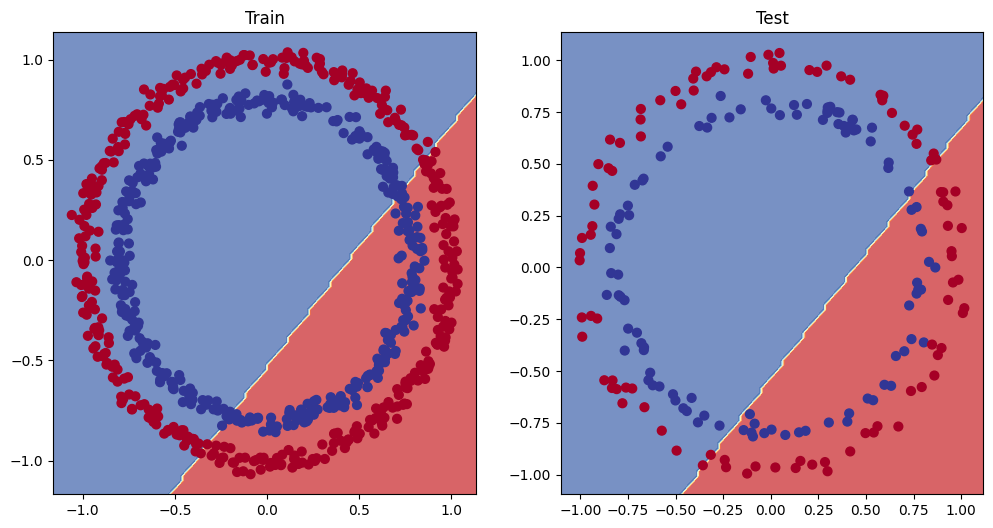

In [23]:
# Plot decision boundaries for training and test data
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

In [24]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2,10)
    self.layer_2 = nn.Linear(10,10)
    self.layer_3 = nn.Linear(10,1)

  def forward(self, x):
    return self.layer_3(self.layer_2(self.layer_1(x)))
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(params=model_1.parameters(),
                            lr = 0.1)

In [26]:
torch.manual_seed(42)

epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_1.train()

  # 1. Forward Pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # 3. Zero Grad
  optimiser.zero_grad()

  # 4. Back propagation
  loss.backward()

  # 5. Step optimiser
  optimiser.step()

  ### Evaluation
  model_1.eval()

  with torch.inference_mode():
    # 1. Forward Pass:
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test accuracy: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test accuracy: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test accuracy: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test accuracy: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test accuracy: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test accuracy: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test accuracy: 46.00%


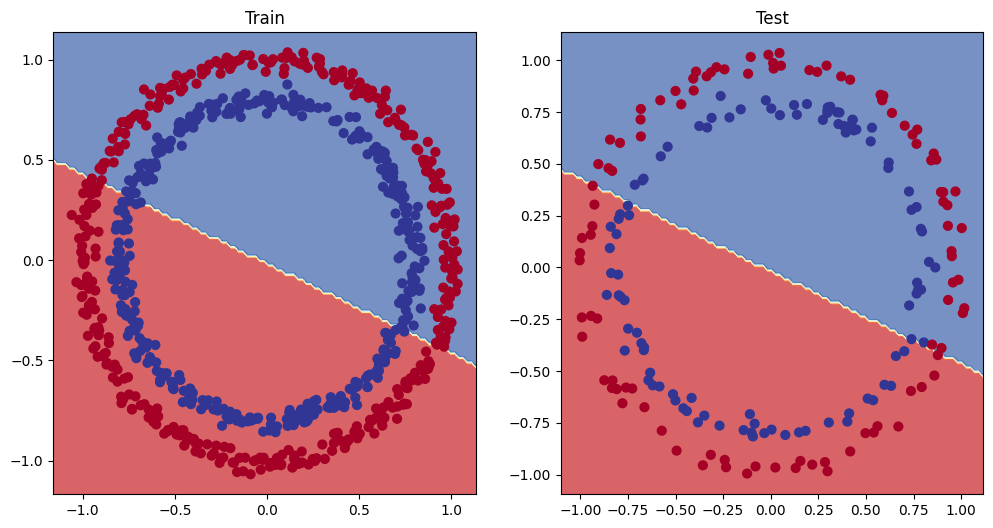

In [27]:
# Plot decision boundaries for training and test set
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can model a straight line

In [28]:
# Create some data (linear)
weight = 0.7
bias = 0.3
start= 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(1)
y_regression = weight * X_regression + bias

print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [29]:
# Create train and test split
train_split = int(0.8 * len(X_regression))

X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check length of each split
print(len(X_train_regression),
      len(y_train_regression),
      len(X_test_regression),
      len(y_test_regression))


80 80 20 20


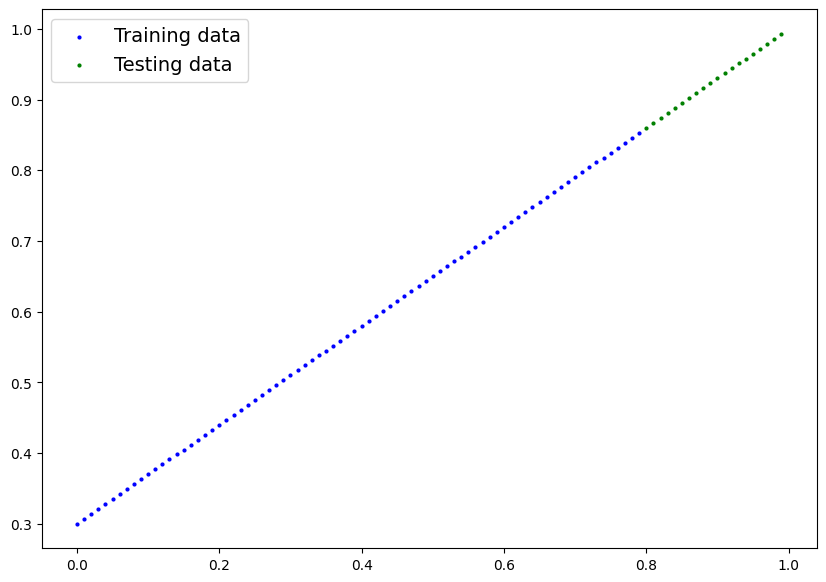

In [30]:
plot_predictions(X_train_regression, y_train_regression,
                 X_test_regression, y_test_regression)

### 5.2 Adjusting model_1 to fit a straight line

In [31]:
# Same architecture as model 1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(1,10),
    nn.Linear(10,10),
    nn.Linear(10,1)
).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
# Loss and Optimiser
loss_fn = nn.L1Loss()
optimiser = torch.optim.SGD(model_2.parameters(), 0.1)

In [33]:
# Set seed
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  ### Training
  model_2.train()

  # 1. Forward Pass
  y_pred = model_2(X_train_regression)

  # 2. Calculate loss
  loss = loss_fn(y_pred, y_train_regression)

  # 3. Optimiser Zero Grad
  optimiser.zero_grad()

  # 4. Back propagation
  loss.backward()

  # 5. Optimiser step
  optimiser.step()

  ### Testing
  model_2.eval()

  with torch.inference_mode():
    # 1. Forward Pass
    test_pred = model_2(X_test_regression)

    # Calculate loss
    test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


Epoch: 0 | Train Loss: 0.75986 | Test Loss: 0.54143
Epoch: 100 | Train Loss: 0.09309 | Test Loss: 0.02901
Epoch: 200 | Train Loss: 0.07376 | Test Loss: 0.02850
Epoch: 300 | Train Loss: 0.06745 | Test Loss: 0.00615
Epoch: 400 | Train Loss: 0.06107 | Test Loss: 0.02004
Epoch: 500 | Train Loss: 0.05698 | Test Loss: 0.01061
Epoch: 600 | Train Loss: 0.04857 | Test Loss: 0.01326
Epoch: 700 | Train Loss: 0.06109 | Test Loss: 0.02127
Epoch: 800 | Train Loss: 0.05600 | Test Loss: 0.01425
Epoch: 900 | Train Loss: 0.05571 | Test Loss: 0.00603


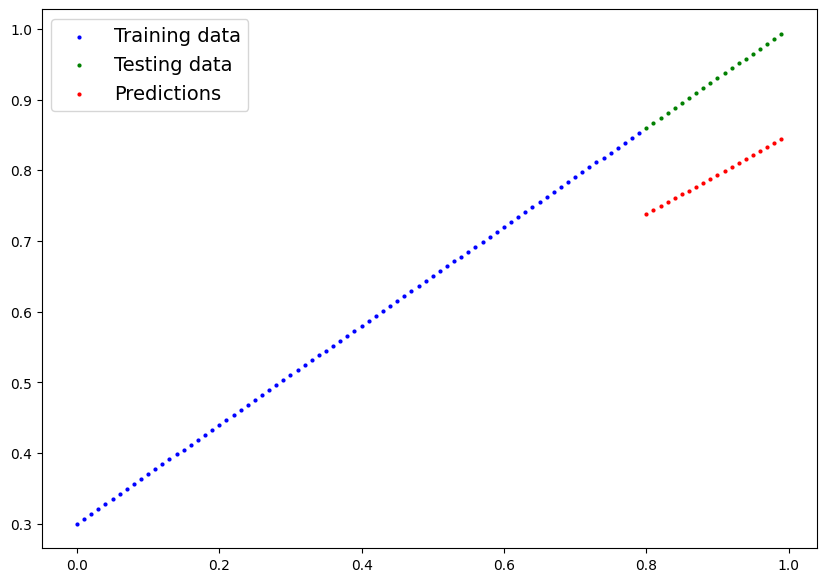

In [34]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(X_train_regression.cpu(),
                 y_train_regression.cpu(),
                 X_test_regression.cpu(),
                 y_test_regression.cpu(),
                 y_preds.cpu())

## 6. The Missing Piece: Non-Linearity

### 6.1 Recreating non-linear data (red and blue circles)

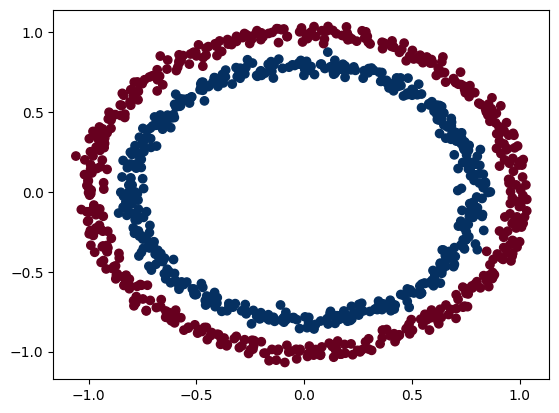

In [35]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
                    noise=0.03,
                    random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdBu)

In [36]:
# Convert into Tensors and split into training and testing set
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into training and testing split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non linearity

In [37]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(2,10)
    self.layer_2 = nn.Linear(10,10)
    self.layer_3 = nn.Linear(10,1)
    self.relu = nn.ReLU()
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2()

print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [38]:
# Set loss and optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(model_3.parameters(), lr=0.1)

### 6.3 Training a model with non-linearity

In [39]:
# Set the random seed
torch.manual_seed(42)

# Set number of epochs
epochs = 1500

# Move data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### Training
  model_3.train()

  # 1. Forward Pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  # 3. Zero Grad
  optimiser.zero_grad()

  # 4. Back propagation
  loss.backward()

  # 5. Optimiser step
  optimiser.step()

  ### Testing
  model_3.eval()

  with torch.inference_mode():
    # 1. Forward Pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # Calculate Loss and Accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1100 | Loss: 0.

### 6.4 Evaluating a model trained with non-linear activation functions

In [40]:
# Make predictions
model_3.eval()

with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

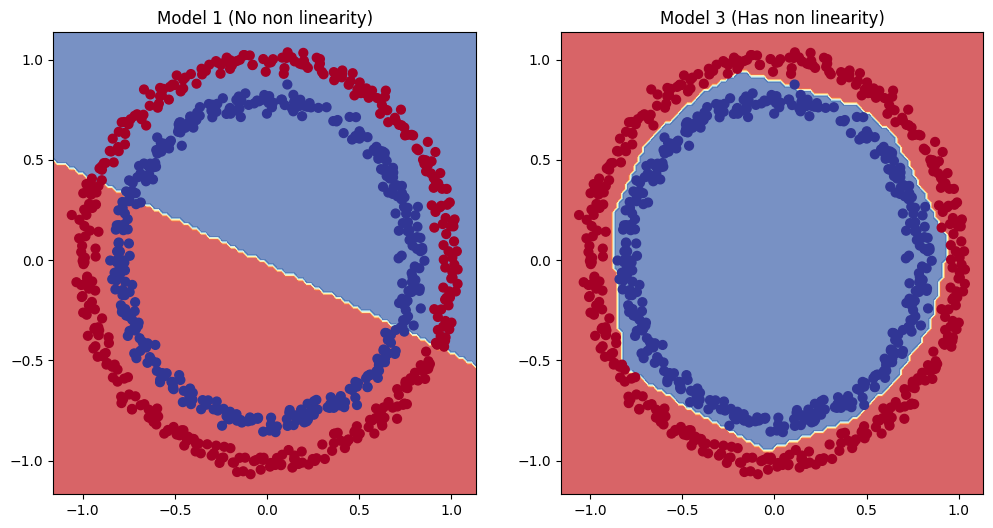

In [41]:
# Plot decision boundary for training and test sets
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Model 1 (No non linearity)")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Model 3 (Has non linearity)")
plot_decision_boundary(model_3, X_train, y_train)


## 7. Replicating non-linear activation functions

In [42]:
# Create a toy tensor (like the data going into our models)

A = torch.arange(-10,10,1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

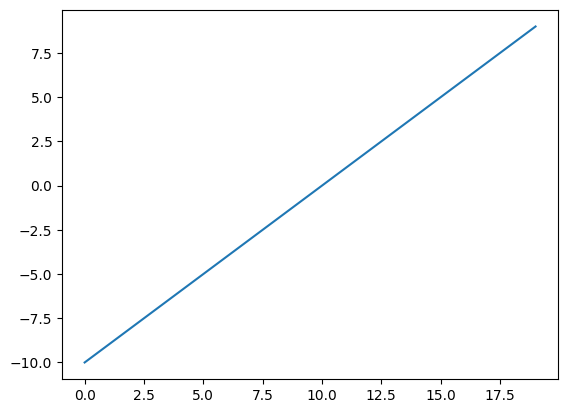

In [43]:
# Visualize the toy tensor
plt.plot(A)

In [44]:
# Create ReLU function by hand

def relu(x):
  return torch.max(torch.tensor(0), x)

# Pass A to relu()
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

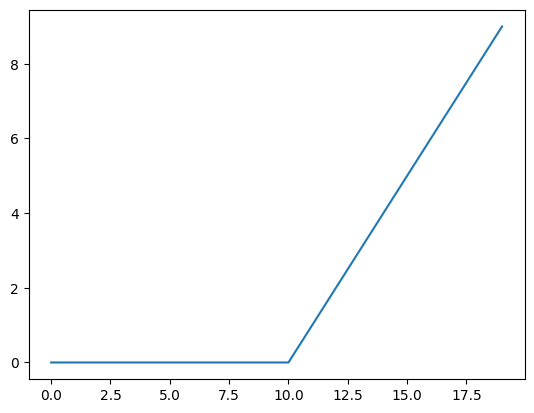

In [45]:
# Plot ReLU activated toy tensor
plt.plot(relu(A))

In [46]:
# Create custom sigmoid function

def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Pass toy tensor through sigmoid function

sigmoid(A)


tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

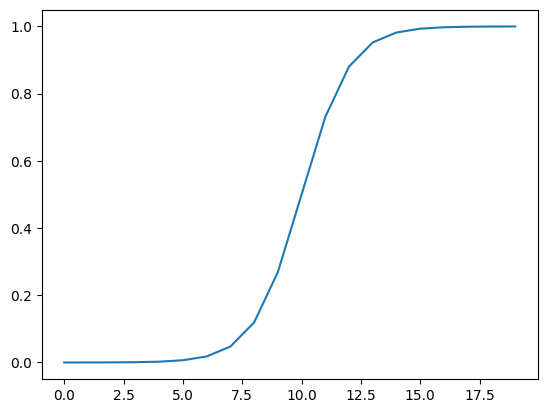

In [47]:
# Plot sigmoid function activated toy tensor
plt.plot(sigmoid(A))

## 8. Putting things together by building a multi-class PyTorch model

### 8.1 Creating mutli-class classification data

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


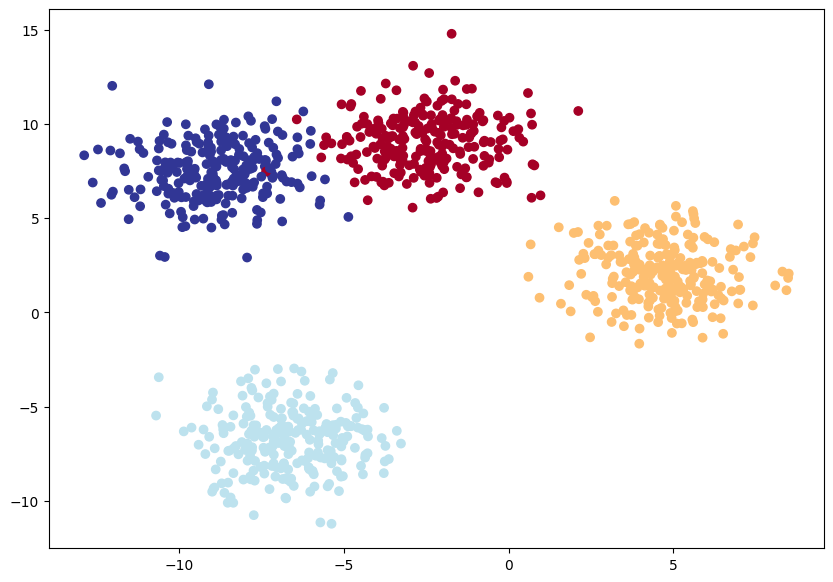

In [48]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multiclass data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features = NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# Split data into train and test set
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# Plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu);

### 8.2 Building a multi-class classification model in PyTorch

In [49]:
# Build model

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.Linear(hidden_units, hidden_units),
        nn.Linear(hidden_units, output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create instance of Blob model and send it to target device
model_4 = BlobModel(NUM_FEATURES,
                    NUM_CLASSES,
                    8).to(device)
model_4



BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

In [50]:
# Create loss and optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In [51]:
# Perform single forward pass

model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)

In [53]:
# How many elements in a single prediction sample
model_4(X_blob_train.to(device))[:5][0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [54]:
# Make prediction logits with model
y_logits = model_4(X_blob_train.to(device))

# Perform softmax calculation on logits across dim 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], grad_fn=<SliceBackward0>)
tensor([[0.1838, 0.3422, 0.1500, 0.3239],
        [0.2199, 0.0377, 0.1839, 0.5586],
        [0.3406, 0.0482, 0.5326, 0.0785],
        [0.3405, 0.0657, 0.4446, 0.1492],
        [0.2527, 0.0424, 0.2283, 0.4766]], grad_fn=<SliceBackward0>)


In [55]:
# Sum the first sample output of the softmax function
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [56]:
# Which class is most likely for sample 0?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1838, 0.3422, 0.1500, 0.3239], grad_fn=<SelectBackward0>)
tensor(1)


### 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [57]:
# Fit the model
torch.manual_seed = 42

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  ### Training
  model_4.train()

  # 1. Forward Pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_pred)

  # 3. Zero grad
  optimiser.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step optimiser
  optimiser.step()

  ### Testing
  model_4.eval()

  with torch.inference_mode():
    # 1. Forward Pass
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    # Calculate loss and accuracy
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}% ")

Epoch: 0 | Loss: 1.04324, Accuracy: 65.50% | Test Loss: 0.57861, Test Accuracy: 95.50% 
Epoch: 10 | Loss: 0.14398, Accuracy: 99.12% | Test Loss: 0.13037, Test Accuracy: 99.00% 
Epoch: 20 | Loss: 0.08062, Accuracy: 99.12% | Test Loss: 0.07216, Test Accuracy: 99.50% 
Epoch: 30 | Loss: 0.05924, Accuracy: 99.12% | Test Loss: 0.05133, Test Accuracy: 99.50% 
Epoch: 40 | Loss: 0.04892, Accuracy: 99.00% | Test Loss: 0.04098, Test Accuracy: 99.50% 
Epoch: 50 | Loss: 0.04295, Accuracy: 99.00% | Test Loss: 0.03486, Test Accuracy: 99.50% 
Epoch: 60 | Loss: 0.03910, Accuracy: 99.00% | Test Loss: 0.03083, Test Accuracy: 99.50% 
Epoch: 70 | Loss: 0.03643, Accuracy: 99.00% | Test Loss: 0.02799, Test Accuracy: 99.50% 
Epoch: 80 | Loss: 0.03448, Accuracy: 99.00% | Test Loss: 0.02587, Test Accuracy: 99.50% 
Epoch: 90 | Loss: 0.03300, Accuracy: 99.12% | Test Loss: 0.02423, Test Accuracy: 99.50% 


### 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [58]:
# Make predictions
model_4.eval()

with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View first 10 predictions
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [60]:
# Turn predicted logits into predicted probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn probabilities into labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 predictions and labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Accuracy: {accuracy_fn(y_blob_test, y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Accuracy: 99.5%


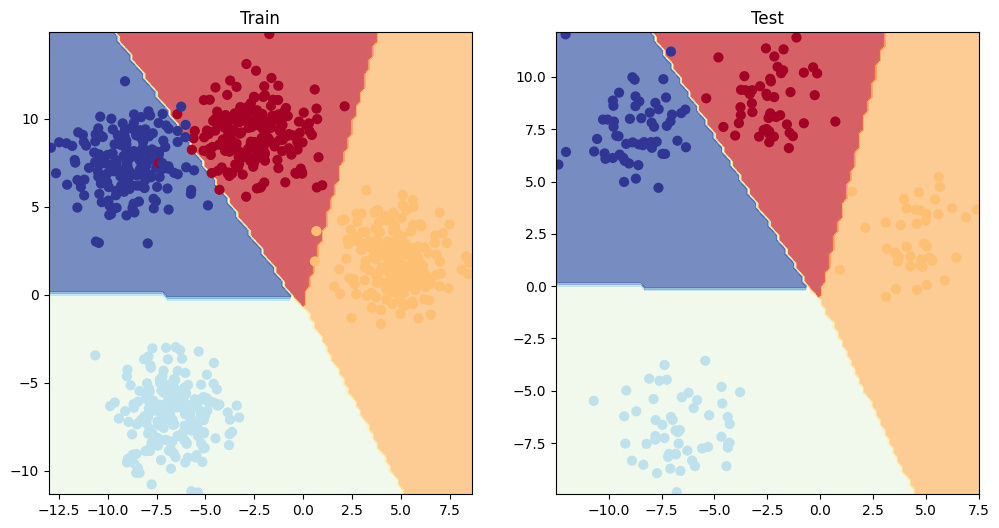

In [61]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

## 9. More classification evaluation metrics

In [63]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics==1.4.1
  from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950)